In [16]:
!pip install yfinance
!pip install transformers
!pip install feedparser
# !pip

In [24]:
import yfinance as yf
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import feedparser
import math

from transformers import pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, r2_score
import math

In [25]:
class StockPredictor:
    def __init__(self, symbol, start, end, keyword):
        self.symbol = symbol
        self.start = start
        self.keyword = keyword
        self.end = end
        self.data = None  # Initialize data as none because of error, then clean it after initialization
        self.clean_data()

    def calculate_RSI(self, period=14):
        delta = self.data['Close'].diff(1)
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)

        avg_gain = gain.rolling(window=period, min_periods=1).mean()
        avg_loss = loss.rolling(window=period, min_periods=1).mean()

        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        return rsi

    def calculate_ATR(self, period=14):
        self.data['High-Low'] = self.data['High'] - self.data['Low']
        self.data['High-PrevClose'] = abs(self.data['High'] - self.data['Close'].shift(1))
        self.data['Low-PrevClose'] = abs(self.data['Low'] - self.data['Close'].shift(1))

        true_range = self.data[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis=1)
        atr = true_range.rolling(window=period).mean()
        return atr

    def calculate_EMA(self, period=14):
        ema = self.data['Close'].ewm(span=period, adjust=False).mean()
        return ema

    def clean_data(self):
        df = yf.Ticker(self.symbol).history(start=self.start, end=self.end)
        if df.empty:
            raise ValueError(f"No data found for {self.symbol}.")

        df = df[['Close', 'High', 'Low']]
        df.index = pd.to_datetime(df.index)

        self.data = df    # Set the dataframe to self.data before calculating indicators

        self.data['RSI'] = self.calculate_RSI()
        self.data['ATR'] = self.calculate_ATR()
        self.data['EMA'] = self.calculate_EMA()

        self.data.dropna(inplace=True)

    def preprocess_data(self, sequence_length=30):
        # Preprocess data for the LSTM model
        features = ['Close', 'RSI', 'ATR', 'EMA']
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(self.data[features])


        x, y = [], []
        for i in range(sequence_length, len(scaled_data)):
            x.append(scaled_data[i-sequence_length:i, :])  # Use all feature columns
            y.append(scaled_data[i, 0])

        x, y = np.array(x), np.array(y)

        x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, shuffle=False)   # Split data into training, validation, and test sets (80% train, 10% val, 10% test)
        x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, shuffle=False)

        return x_train, y_train, x_val, y_val, x_test, y_test, scaler

    def build_lstm_model(self):
        model = Sequential()

        model.add(LSTM(units=128, return_sequences=True, input_shape=(30, 4)))
        model.add(Dropout(0.3))

        # model.add(LSTM(units=128, return_sequences=True))
        # model.add(Dropout(0.2))

        model.add(LSTM(units=64, return_sequences=False))
        model.add(Dropout(0.3))

        # model.add(LSTM(units=64, return_sequences=False))
        # model.add(Dropout(0.2))

        model.add(Dense(units=32))
        model.add(Dropout(0.2))

        model.add(Dense(units=1))

        model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mape'])
        model.summary()

        return model

    def train_lstm(self, epochs=50, batch_size=32):
        x_train, y_train, x_val, y_val, _, _, _ = self.preprocess_data()
        model = self.build_lstm_model()

        # Early stopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Learning rate scheduler (Reduce LR on Plateau)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1)

        history = model.fit(
            x_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(x_val, y_val),
            callbacks=[early_stopping, reduce_lr]
        )

        self.lstm_model = model
        self.history = history
        self.lstm_model.save('Project-Ritchie.h5')
        print("Model saved as 'Project-Ritchie.h5'")

        # Plot Training and Validation Loss
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def test_lstm(self):
        x_train, y_train, x_val, y_val, x_test, y_test, scaler = self.preprocess_data()

        # Prediction
        test_predictions = self.lstm_model.predict(x_test)
        pad_test_predictions = np.zeros((test_predictions.shape[0], 4))
        pad_test_predictions[:, 0] = test_predictions[:, 0]

        # Inverse transform
        test_predictions_inv = scaler.inverse_transform(pad_test_predictions)[:, 0]
        y_test_actual = scaler.inverse_transform(np.pad(y_test.reshape(-1, 1), ((0, 0), (0, 3))))[:, 0]

        # Metrics Calculation
        rmse = math.sqrt(mean_squared_error(y_test_actual, test_predictions_inv))
        mape = mean_absolute_percentage_error(y_test_actual, test_predictions_inv) * 100
        mae = mean_absolute_error(y_test_actual, test_predictions_inv)
        mse = mean_squared_error(y_test_actual, test_predictions_inv)
        r2 = r2_score(y_test_actual, test_predictions_inv)
        mbd = np.mean(test_predictions_inv - y_test_actual)  # Mean Bias Deviation

        # Print metrics
        print(f"Test RMSE: {rmse:.2f}")
        print(f"Test MAPE: {mape:.2f}%")
        print(f"Test MAE: {mae:.2f}")
        print(f"Test MSE: {mse:.2f}")
        print(f"Test R² Score: {r2:.4f}")
        print(f"Test MBD: {mbd:.2f}")

        # Plot actual vs predicted values
        plt.figure(figsize=(10, 6))
        plt.plot(y_test_actual, label='Actual Test Data', color='blue')
        plt.plot(test_predictions_inv, label='Predicted Test Data', color='red')
        plt.title(f'{self.symbol} Stock Price: Test Data Prediction vs Actual')
        plt.xlabel('Time')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.grid(True)
        plt.show()

    # Methods for MACD, Stochastic Oscillator, Bollinger Bands, and Fibonacci Retracement
    def macd(self):
        short_ema = self.data['Close'].ewm(span=12, adjust=False).mean()
        long_ema = self.data['Close'].ewm(span=26, adjust=False).mean()
        self.data['MACD'] = short_ema - long_ema
        self.data['Signal_Line'] = self.data['MACD'].ewm(span=9, adjust=False).mean()
        self.data['MACD_Signal'] = np.where(self.data['MACD'] > self.data['Signal_Line'], 1, 0)
        return self.data['MACD_Signal'].iloc[-1]

    def stochastic_oscillator(self, window=14):
        low_min = self.data['Close'].rolling(window=window).min()
        high_max = self.data['Close'].rolling(window=window).max()
        self.data['%K'] = 100 * ((self.data['Close'] - low_min) / (high_max - low_min))
        self.data['%D'] = self.data['%K'].rolling(window=3).mean()
        self.data['Stochastic_Signal'] = np.where(self.data['%K'] > self.data['%D'], 1, 0)
        return self.data['Stochastic_Signal'].iloc[-1]

    def bollinger_bands(self, window=20):
        self.data['MA'] = self.data['Close'].rolling(window=window).mean()
        self.data['BB_Upper'] = self.data['MA'] + (self.data['Close'].rolling(window=window).std() * 2)
        self.data['BB_Lower'] = self.data['MA'] - (self.data['Close'].rolling(window=window).std() * 2)
        self.data['BB_Signal'] = np.where(self.data['Close'] < self.data['BB_Lower'], 1,
                                          np.where(self.data['Close'] > self.data['BB_Upper'], 0, np.nan))
        return self.data['BB_Signal'].dropna().iloc[-1]

    def fibonacci_retracement(self):
        max_price = self.data['Close'].max()
        min_price = self.data['Close'].min()
        diff = max_price - min_price
        levels = {
            'Level_23.6%': max_price - 0.236 * diff,
            'Level_38.2%': max_price - 0.382 * diff,
            'Level_50.0%': max_price - 0.500 * diff,
            'Level_61.8%': max_price - 0.618 * diff,
            'Level_100%': min_price
        }
        current_price = self.data['Close'].iloc[-1]
        if current_price < levels['Level_23.6%']:
            return 1
        elif current_price > levels['Level_61.8%']:
            return 0
        else:
            return np.nan

    def market_sentiment(self):
      ticker = self.symbol
      keyword = self.keyword
      print(f'Ticker: {ticker}')
      print(f'Keyword: {keyword}')

      pipe = pipeline("text-classification", model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
      feed = feedparser.parse(f'https://finance.yahoo.com/rss/headline?s={ticker}')
      total_score = 0
      num_articles = 0

      for i, entry in enumerate(feed.entries):
        if keyword.lower() not in entry.summary.lower():
          continue

        print(f'Title: {entry.title}')
        print(f'Link: {entry.link}')
        print(f'Summary: {entry.summary}')
        print(f'Published: {entry.published}')

        sentiment = pipe(entry.summary)[0]
        print(f'Sentiment: {sentiment["label"]}, Score: {sentiment["score"]}')
        print('-' *40)

        if sentiment['label'] == 'positive':
          total_score += sentiment['score']
          num_articles += 1
        elif sentiment['label'] == 'negative':
          total_score -= sentiment['score']
          num_articles += 1

      if num_articles > 0: # Added if statement to avoid division by zero error
          final_score = total_score / num_articles
          print(f'Overall Sentiment:{"Positive" if final_score >= 0.15 else "Negative" if total_score <= -0.15 else "Neutral"} {final_score}')
      else:
          print('No articles found with the specified keyword.')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                       │ (None, 30, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_21 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 119,617 (467.25 KB)

 Trainable params: 119,617 (467.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0068 - mape: 98.1489 - val_loss: 0.0025 - val_mape: 7.7158 - learning_rate: 0.0010
Epoch 2/70
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.3153e-04 - mape: 32.3942 - val_loss: 0.0044 - val_mape: 10.4314 - learning_rate: 0.0010
Epoch 3/70
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.2420e-04 - mape: 26.5935 - val_loss: 0.0029 - val_mape: 8.7554 - learning_rate: 0.0010
Epoch 4/70
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.3265e-04 - mape: 28.6041 - val_loss: 0.0024 - val_mape: 7.8264 - learning_rate: 0.0010
Epoch 5/70
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.3271e-04 - mape: 23.4101 - val_loss: 0.0027 - val_mape: 8.0929 - learning_rate: 0.0010
Epoch 6/70
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.9524e-04 - mape: 24.2804 - val_loss: 7.2060e-04 - val_mape: 3.9196 - learning_rate: 0.0010
Epoch 7/70
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.9511e-04 - mape: 22.7639 - val_loss: 0.0036 - val_mape:

Model saved as 'Project-Ritchie.h5'


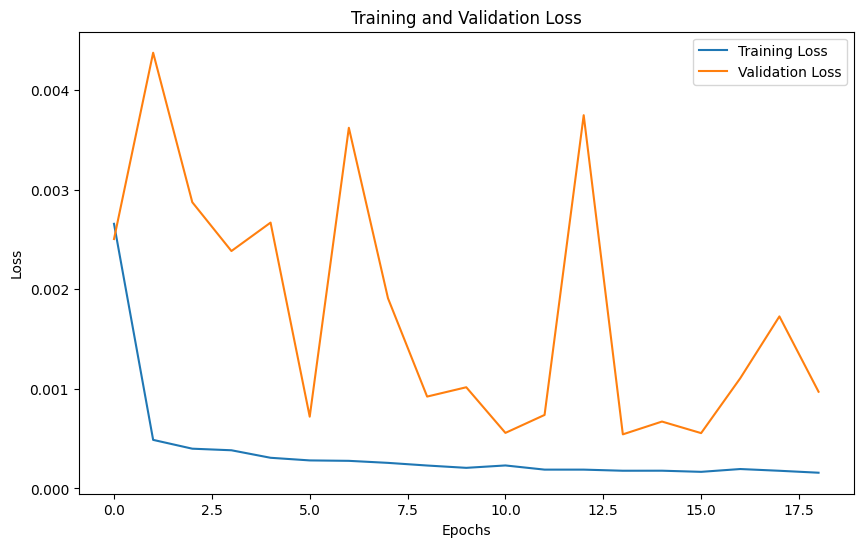

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test RMSE: 6.52
Test MAPE: 3.25%
Test MAE: 5.17
Test MSE: 42.45
Test R² Score: 0.8624
Test MBD: -1.76


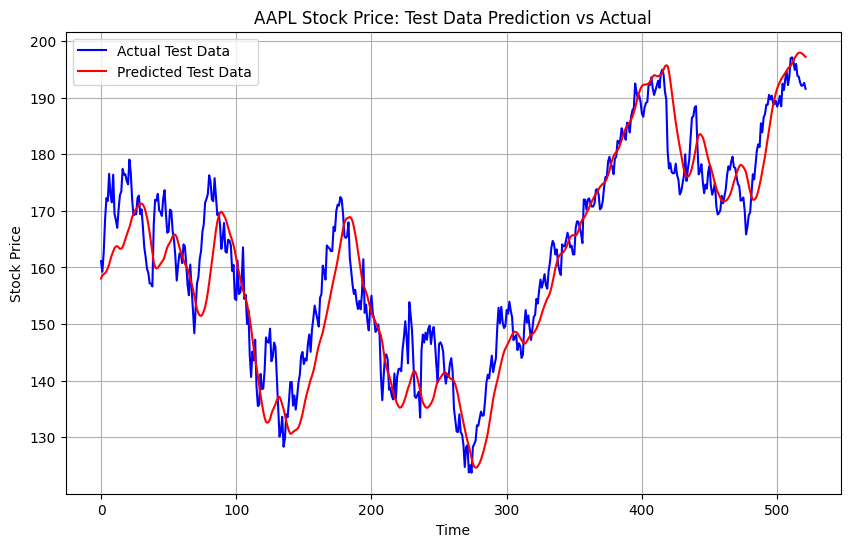

Ticker: AAPL
Keyword: apple


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Title: Magnificent Seven Stocks: Nvidia Stock Rebounds; Tesla Slides From Record Highs
Link: https://finance.yahoo.com/m/4205eaa9-f620-3a0b-a81a-0e82c7c9fd0b/magnificent-seven-stocks%3A.html?.tsrc=rss
Summary: Dubbed the Magnificent Seven stocks, Apple, Microsoft, Google parent Alphabet, Amazon.com, Nvidia, Meta Platforms and Tesla lived up to their name in 2023 with big gains. And all of them boasted solid year-to-date gains in the final month of 2024.
Published: Wed, 18 Dec 2024 15:11:42 +0000
Sentiment: positive, Score: 0.9996744394302368
----------------------------------------
Title: Why the Mag 7 trade is far from over: Chart of the Day
Link: https://finance.yahoo.com/video/why-mag-7-trade-far-150624384.html?.tsrc=rss
Summary: Bank of America (BAC) released its Global Fund Manager Survey on Tuesday, offering market insights from top institutional, mutual, and hedge fund managers. Today's Chart of the Day features anchor Madison Mills examining the increasing allocation to the Mag

In [27]:
# symbol = input("Enter the stock symbol: ")
symbol = 'AAPL'
start = '2010-01-01'
end = '2024-01-01'
keyword = 'apple'

predictor = StockPredictor(symbol, start, end, keyword)

# Train the LSTM model
predictor.train_lstm(epochs=70, batch_size=32)

# Test the LSTM model and visualize the results
predictor.test_lstm()
predictor.market_sentiment()

# predictor.market_sentiment()

macd_signal = predictor.macd()
stochastic_signal = predictor.stochastic_oscillator()
bollinger_signal = predictor.bollinger_bands()
fibonacci_signal = predictor.fibonacci_retracement()

print(f"MACD Signal: {macd_signal}, Stochastic Oscillator Signal: {stochastic_signal}, Bollinger Bands Signal: {bollinger_signal}, Fibonacci Signal: {fibonacci_signal}")

In [30]:
def automated_stock_prediction(model_path, symbol, start_date, end_date, future_days=30, time_step=30):
    """
    Predict future stock prices in a fully automated manner and compare predictions with actual prices (if available).

    Parameters:
        model_path (str): Path to the saved LSTM model file.
        symbol (str): Stock symbol to fetch data for.
        start_date (str): Start date for fetching historical data.
        end_date (str): End date for fetching historical data.
        future_days (int): Number of future days to predict.
        time_step (int): Number of past timesteps to use for predictions.

    Returns:
        future_prices (array): Predicted future prices.
    """

    def calculate_rsi(data, period=14):
        delta = data.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi

    def calculate_atr(high, low, close, period=14):
        tr1 = high - low
        tr2 = abs(high - close.shift())
        tr3 = abs(low - close.shift())
        true_range = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
        atr = true_range.rolling(window=period).mean()
        return atr

    def calculate_ema(data, period=14):
        return data.ewm(span=period, adjust=False).mean()

    # Load the trained model
    model = load_model(model_path)
    print("Model loaded successfully.")

    # Fetch stock data
    df = yf.Ticker(symbol).history(start=start_date, end=end_date)
    df.tail()
    if df.empty:
        raise ValueError(f"No data found for {symbol}.")

    print(f"Fetched {len(df)} rows of data for {symbol}.")

    # Calculate technical indicators
    df['RSI'] = calculate_rsi(df['Close'])
    df['ATR'] = calculate_atr(df['High'], df['Low'], df['Close'])
    df['EMA'] = calculate_ema(df['Close'])

    # Drop NaN values introduced by indicator calculations
    df = df.dropna()

    # Ensure enough timesteps for prediction
    if len(df) < time_step:
        raise ValueError(f"Not enough data to generate {time_step} timesteps. Provide more historical data.")

    # Scale the features
    feature_columns = ['Close', 'RSI', 'ATR', 'EMA']
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[feature_columns].values)

    # Prepare the initial input data
    last_data = scaled_data[-time_step:]  # Use the last 'time_step' rows
    last_data = last_data.reshape(1, time_step, len(feature_columns))  # Model expects 3D input

    predictions = []

    # Predict future prices iteratively
    new_data = df[feature_columns].values[-(time_step + 1):].tolist()  # Store the last few rows of data for recalculation

    for _ in range(future_days):
        # Predict the next price
        predicted_price = model.predict(last_data)[0][0]
        predictions.append(predicted_price)

        # Calculate High and Low using a 1% shift from the predicted Close
        predicted_high = predicted_price * 1.01  # High is 1% above Close
        predicted_low = predicted_price * 0.99  # Low is 1% below Close

        # Recalculate technical indicators using the predicted price
        close_prices = [row[0] for row in new_data] + [predicted_price]  # Append the predicted price
        rsi = calculate_rsi(pd.Series(close_prices)).iloc[-1]  # Recalculate RSI
        atr = calculate_atr(
            pd.Series([row[1] for row in new_data] + [predicted_high]),  # High is 1% above Close
            pd.Series([row[2] for row in new_data] + [predicted_low]),   # Low is 1% below Close
            pd.Series(close_prices)
        ).iloc[-1]
        ema = calculate_ema(pd.Series(close_prices)).iloc[-1]

        # Create the new scaled row
        new_row = scaler.transform([[predicted_price, rsi, atr, ema]])[0]  # Scale the new input
        new_data.append([predicted_price, rsi, atr, ema])  # Append to raw list (for recalculation)

        # Update 'last_data' for the next iteration
        last_data_scaled = np.append(last_data[:, 1:, :], [[new_row]], axis=1)
        last_data = last_data_scaled

    # Inverse transform the predictions for actual price values
    predicted_prices = scaler.inverse_transform(
        np.hstack([np.array(predictions).reshape(-1, 1),
                  np.zeros((len(predictions), len(feature_columns) - 1))])
    )[:, 0]  # Extract only the 'Close' price

    # Generate future dates for plotting
    last_date = df.index[-1] if isinstance(df.index, pd.DatetimeIndex) else pd.Timestamp.now()
    future_dates = pd.date_range(last_date, periods=future_days + 1)[1:]  # Exclude last_date

    # Fetch actual future prices (if available) for comparison
    actual_future_data = yf.Ticker(symbol).history(start=future_dates[0], end=future_dates[-1] + pd.Timedelta(days=1))
    actual_future_prices = actual_future_data['Close'].reindex(future_dates, method='nearest') if not actual_future_data.empty else None

    # Plot the predicted future prices
    plt.figure(figsize=(12, 6))
    plt.plot(future_dates, predicted_prices, label="Predicted Future Prices", color='green')
    if actual_future_prices is not None:
        plt.plot(actual_future_prices.index, actual_future_prices.values, label="Actual Future Prices", color='blue')
    else:
        print("No actual future prices available for comparison.")
    plt.title(f"Future Price Predictions for {symbol}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

    return predicted_prices


Model loaded successfully.
Fetched 60 rows of data for AAPL.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

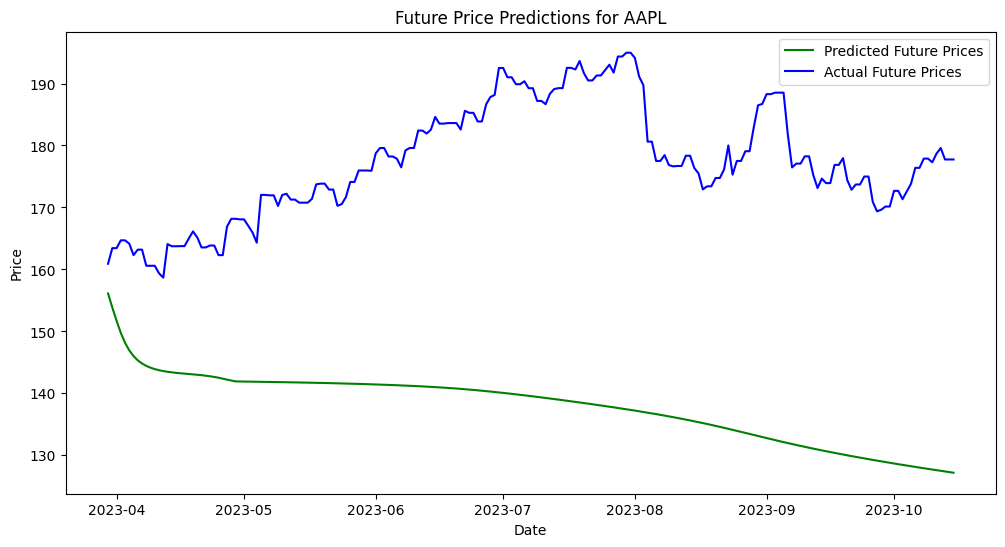

In [35]:
# Path to the saved LSTM model
model_path = "Project-Ritchie.h5"

# Predict future prices for AAPL
predicted_prices = automated_stock_prediction(
    "Project-Ritchie.h5",
    "AAPL",
    start_date="2023-01-01",
    end_date="2023-03-30",
    future_days=200,
    time_step=30
)